# Séparation des jeux de données d'entraînement et de tests

In [3]:
from ift6758.data import load_cached_seasons_dataframe, load_cached_season_dataframe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="ticks")

In [4]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin
# len(df_test)

In [7]:
def new_variables(df, goal_x=89.0, goal_y=0.0, x_col="x", y_col="y", event_col="typeEvent", empty_col="openNet"):
    ndf = df.copy()
    
    dx = goal_x - ndf[x_col].abs()  # on calcule ici la distance au but
    dy = ndf[y_col] - goal_y
    ndf["shotDistance"] = np.sqrt(dx**2 + dy**2)
    ndf["shotAngle"] = np.degrees(np.arctan2(dy.abs(), dx))
    ndf["isGoal"] = ndf[event_col].astype(str).str.lower().eq("goal")
    ndf["isEmpty"] = ndf[empty_col].fillna(0).astype(int).eq(1)
    
    return ndf

new_variables(df_training)

,timeInPeriod,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,typeShot,openNet,goalStrenght,gameId,season,gameType,shotDistance,shotAngle,isGoal,isEmpty
0,01:11,1,8,TOR,shot-on-goal,-77.0,5.0,Mitch Marner,Craig Anderson,wrist,False,EV,2016020001,2016,2,13.000000,22.619865,False,False
1,02:53,1,11,OTT,shot-on-goal,86.0,13.0,Chris Kelly,Frederik Andersen,wrist,False,EV,2016020001,2016,2,13.341664,77.005383,False,False
2,04:01,1,15,OTT,shot-on-goal,23.0,-38.0,Cody Ceci,Frederik Andersen,wrist,False,EV,2016020001,2016,2,76.157731,29.931512,False,False
3,04:46,1,16,OTT,shot-on-goal,33.0,-15.0,Erik Karlsson,Frederik Andersen,slap,False,EV,2016020001,2016,2,57.974132,14.995079,False,False
4,06:46,1,24,TOR,shot-on-goal,-34.0,28.0,Martin Marincin,Craig Anderson,wrist,False,EV,2016020001,2016,2,61.717096,26.980231,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327677,16:01,3,706,TBL,shot-on-goal,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,snap,False,SH,2019030416,2019,3,38.418745,38.659808,False,False
327678,17:20,3,709,TBL,shot-on-goal,-81.0,3.0,Blake Coleman,Anton Khudobin,wrist,False,SH,2019030416,2019,3,8.544004,20.556045,False,False
327679,18:50,3,713,DAL,shot-on-goal,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,snap,False,EV,2019030416,2019,3,55.326305,6.225829,False,False
327680,19:27,3,719,DAL,shot-on-goal,31.0,10.0,John Klingberg,Andrei Vasilevskiy,wrist,False,EV,2019030416,2019,3,58.855756,9.782407,False,False


# Histogramme des tirs cadrés (buts et non-buts) par distance

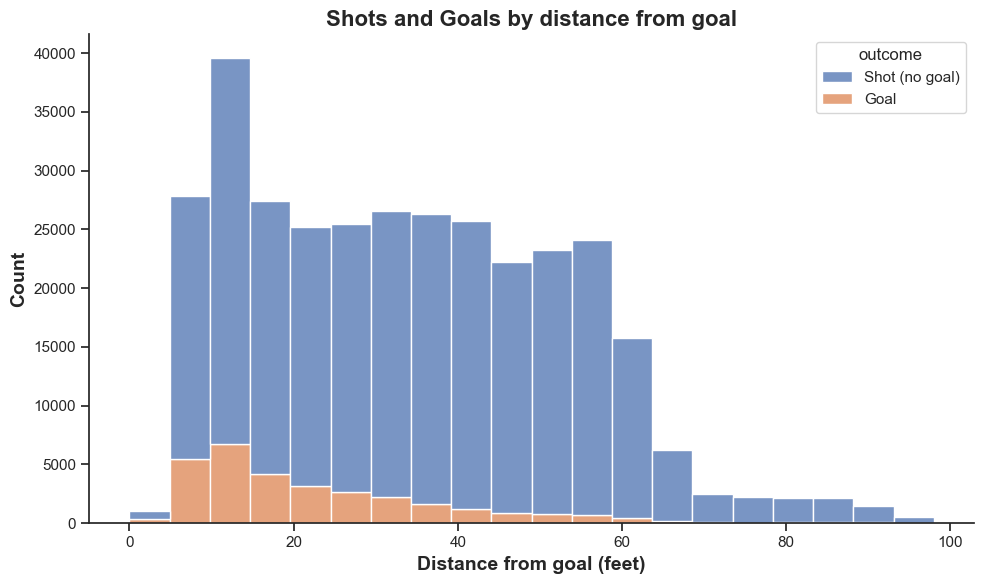

In [8]:
df = new_variables(df_training)

# On veut 2 catégories : Goal vs Shot (non-goal)
df["outcome"] = np.where(df["isGoal"], "Goal", "Shot (no goal)")

plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df,
    x="shotDistance",
    hue="outcome",
    multiple="stack",
    binwidth=5
)

sns.despine()
ax.grid(False)
ax.set_title("Shots and Goals by distance from goal", fontsize=16, fontweight="bold")
ax.set_xlabel("Distance from goal (feet)", fontsize=14, fontweight="bold")
ax.set_ylabel("Count", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Histogramme des tirs cadrés (buts et non-buts) par angle de tir

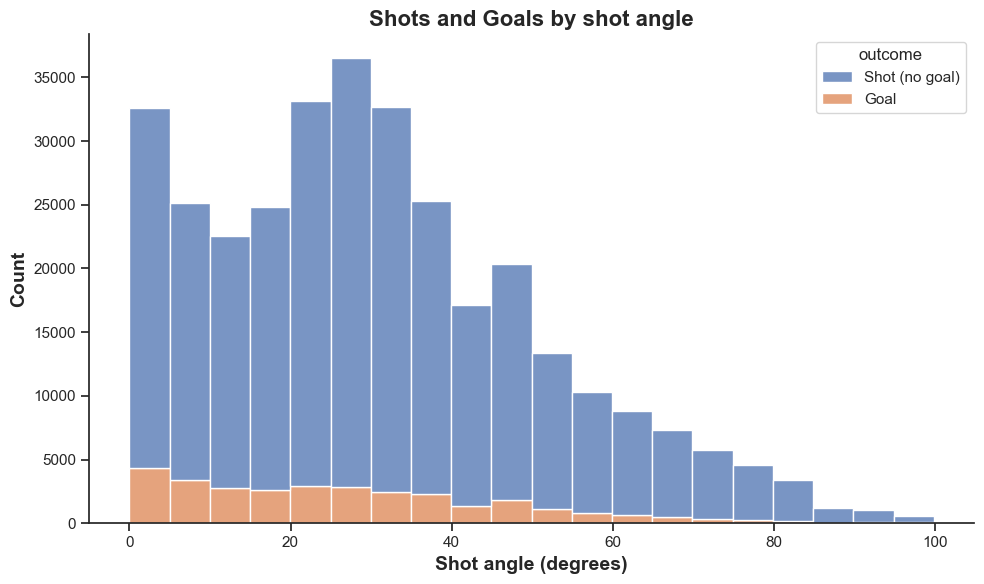

In [10]:
df_angle = df[df["shotAngle"].between(0, 100)].copy()

plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_angle,
    x="shotAngle",
    hue="outcome",
    multiple="stack",
    binwidth=5
)

sns.despine()
ax.grid(False)
ax.set_title("Shots and Goals by shot angle", fontsize=16, fontweight="bold")
ax.set_xlabel("Shot angle (degrees)", fontsize=14, fontweight="bold")
ax.set_ylabel("Count", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Histogramme 2D de la densité des tirs en fonction de la distance et de l’angle

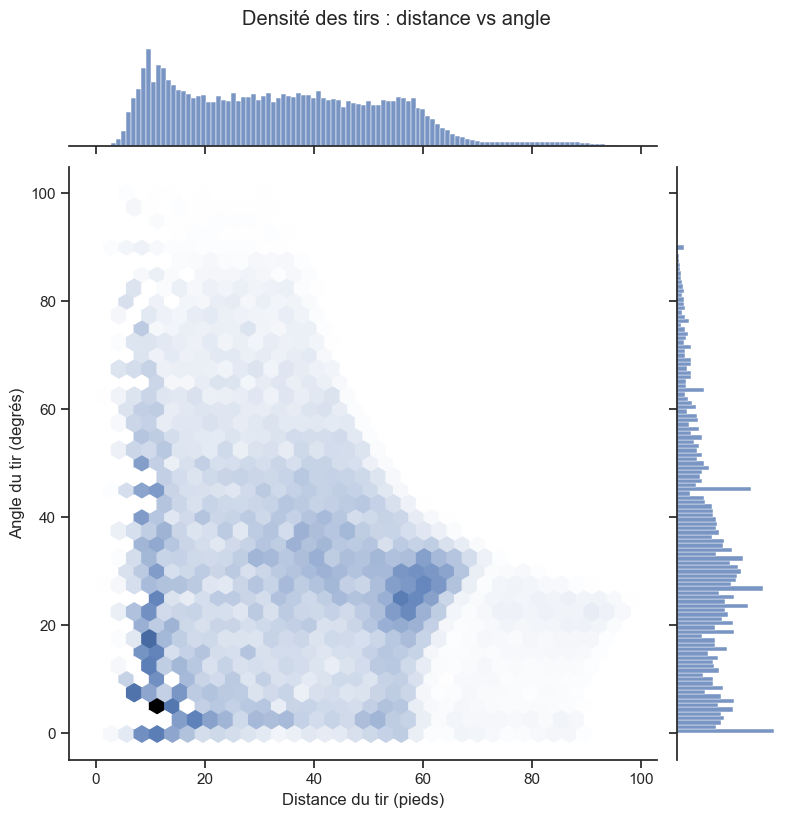

In [13]:
df_all = df.copy()
df_all = df_all[df_all["shotAngle"].between(0, 100)]

g = sns.jointplot(
    data=df_all,
    x="shotDistance",
    y="shotAngle",
    kind="hex",
    gridsize=35,
    height=8
)

g.set_axis_labels("Distance du tir (pieds)", "Angle du tir (degrés)")
g.fig.suptitle("Densité des tirs : distance vs angle", y=1.02)
plt.show()

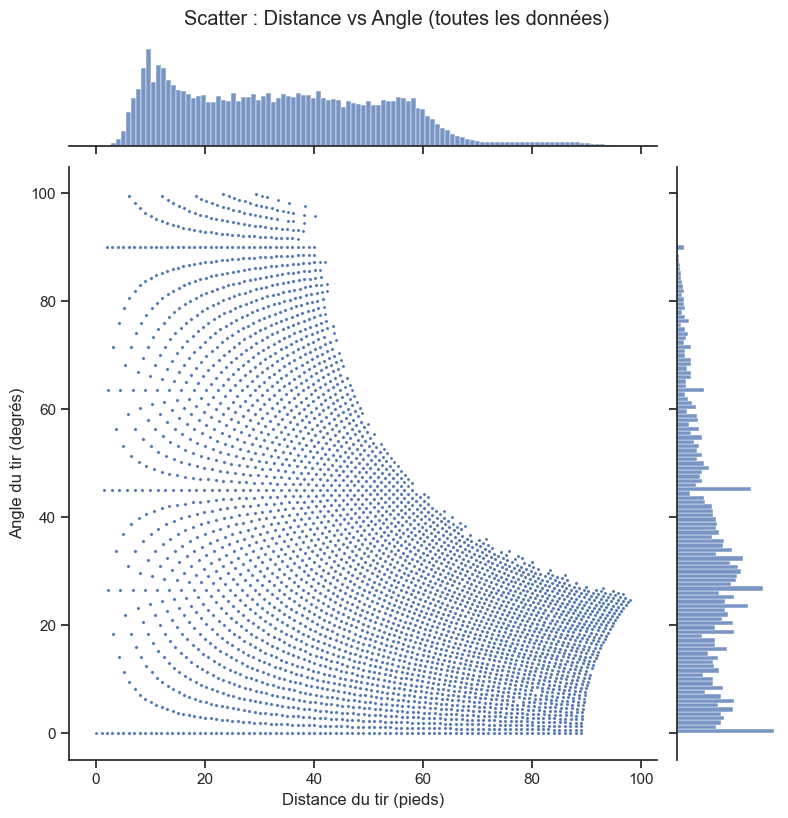

In [19]:
# si on trouve ca plus cool ?
df_scatter = df.copy()
df_scatter = df_scatter[df_scatter["shotAngle"].between(0, 100)]

g = sns.jointplot(
    data=df_scatter,
    x="shotDistance",
    y="shotAngle",
    kind="scatter",
    joint_kws={
        "s": 5, 
        "alpha": 1     
    },
    height=8
)

g.set_axis_labels("Distance du tir (pieds)", "Angle du tir (degrés)")
g.fig.suptitle("Scatter : Distance vs Angle (toutes les données)", y=1.02)
plt.show()

# Taux de but en fonction de la distance

C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\3393310902.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_bin")
C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\3393310902.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["typeEvent"] == "goal").sum() * 100 / len(x))


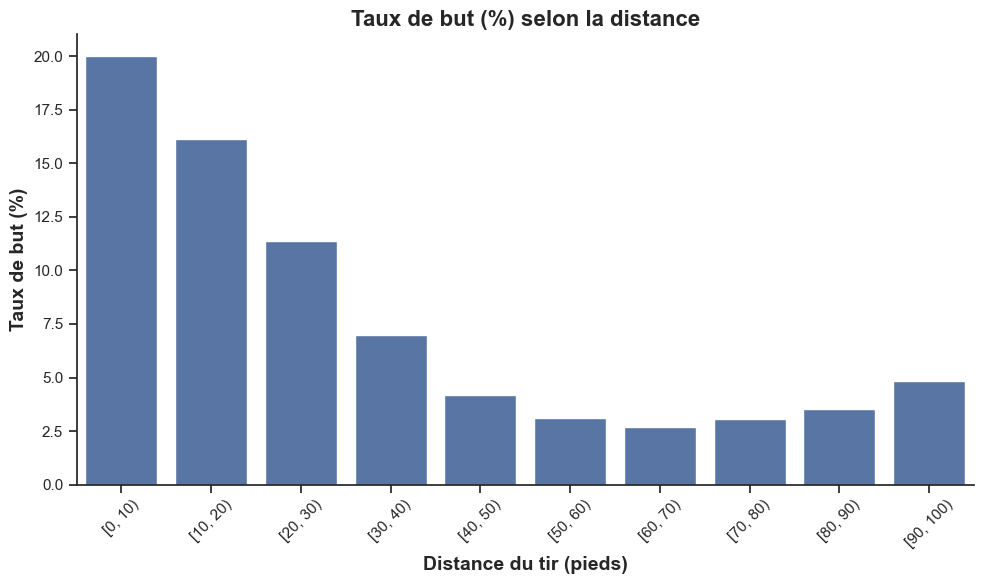

In [26]:
df = df.copy()

bin_width = 10
bins = range(0, int(df["shotDistance"].max()) + bin_width, bin_width)
df["distance_bin"] = pd.cut(df["shotDistance"], bins=bins, right=False)

success_rate = (
    df.groupby("distance_bin")
      .apply(lambda x: (x["typeEvent"] == "goal").sum() * 100 / len(x))
      .reset_index(name="success_rate")
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=success_rate, x="distance_bin", y="success_rate")
sns.despine()
ax.grid(False)
ax.set_title("Taux de but (%) selon la distance", fontsize=16, fontweight="bold")
ax.set_xlabel("Distance du tir (pieds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Taux de but (%)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Taux de but en fonction de l'angle de tir

C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\340077753.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("angle_bin")
C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\340077753.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["typeEvent"] == "goal").sum() * 100 / len(x))


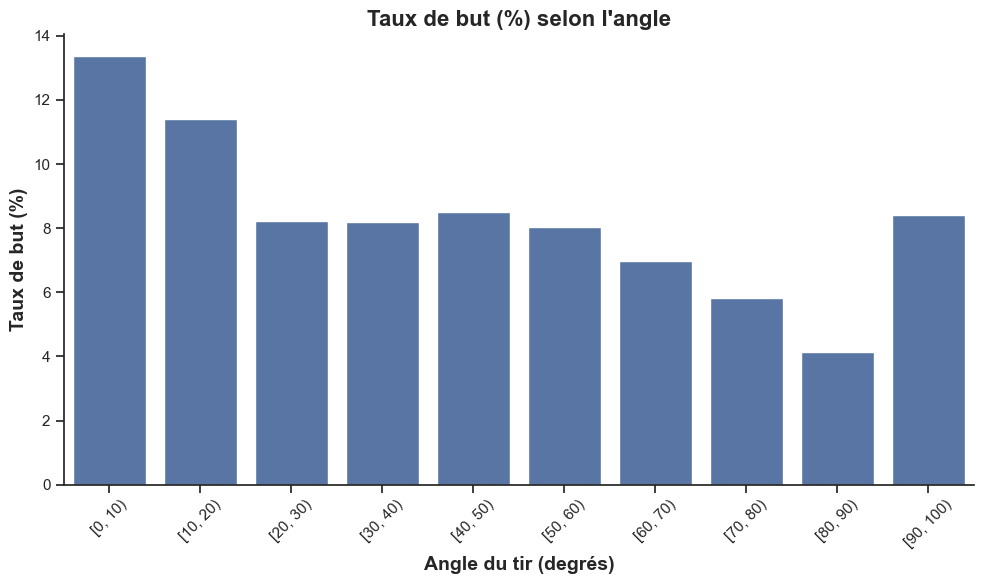

In [28]:
df = df.copy()
df = df[df["shotAngle"].between(0, 100)]

bin_width = 10
bins = range(0, 100 + bin_width, bin_width)
df["angle_bin"] = pd.cut(df["shotAngle"], bins=bins, right=False)

success_rate = (
    df.groupby("angle_bin")
      .apply(lambda x: (x["typeEvent"] == "goal").sum() * 100 / len(x))
      .reset_index(name="success_rate")
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=success_rate, x="angle_bin", y="success_rate")
sns.despine()
ax.grid(False)
ax.set_title("Taux de but (%) selon l'angle", fontsize=16, fontweight="bold")
ax.set_xlabel("Angle du tir (degrés)", fontsize=14, fontweight="bold")
ax.set_ylabel("Taux de but (%)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogramme du taux de succès, pour un but vide ou pas

C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\3776426011.py:20: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  ax.legend(handles=handles, labels=["Goalie présent", "Filet vide"],
C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_4756\3776426011.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handles=handles, labels=["Goalie présent", "Filet vide"],


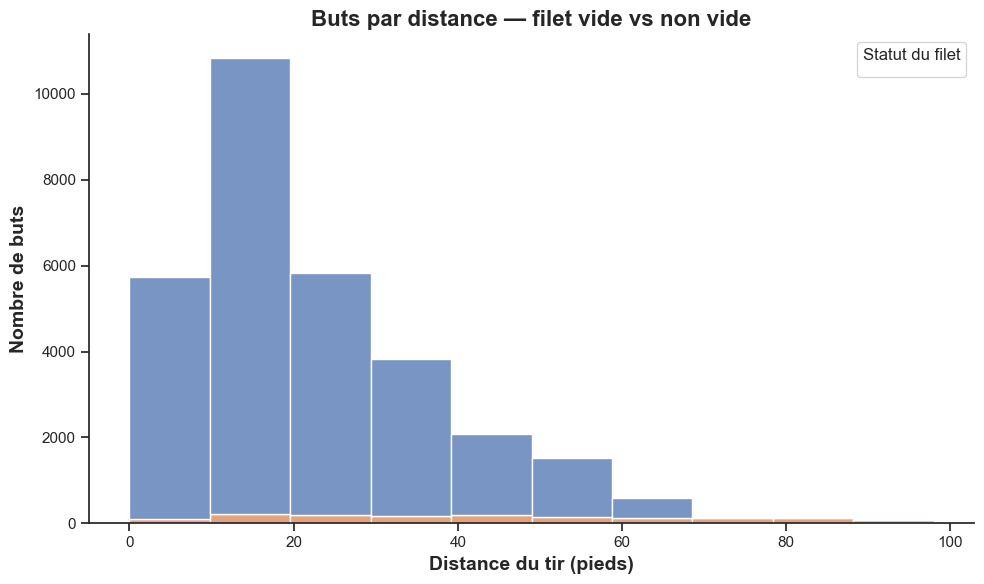

In [30]:
df_goals = df[df["typeEvent"] == "goal"].copy()

plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_goals,
    x="shotDistance",
    hue="isEmpty",          # False/True
    multiple="stack",       # empilé
    binwidth=10
)

sns.despine()
ax.grid(False)
ax.set_title("Buts par distance — filet vide vs non vide", fontsize=16, fontweight="bold")
ax.set_xlabel("Distance du tir (pieds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Nombre de buts", fontsize=14, fontweight="bold")

# légende propre
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Goalie présent", "Filet vide"],
          title="Statut du filet", loc="upper right")

plt.tight_layout()
plt.show()